[View in Colaboratory](https://colab.research.google.com/gist/naviarh/bb07058aac7dbe338e07648285cad835/fastai1.ipynb)

In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

In [0]:
!pip install --upgrade pip
!pip3 install fastai

In [3]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!pwd

/content


In [4]:
import subprocess, os
os.uname()

posix.uname_result(sysname='Linux', nodename='c9a8014febf4', release='4.14.33+', version='#1 SMP Wed Jun 20 01:15:52 PDT 2018', machine='x86_64')

In [5]:
from fastai.conv_learner import *
!pip3 show fastai torch | grep Name -A 1

Name: fastai
Version: 0.7.0
--
Name: torch
Version: 0.3.1


In [0]:
#from fastai.imports import *
#from fastai.transforms import *
#from fastai.conv_learner import *
#from fastai.model import *
#from fastai.dataset import *
#from fastai.sgdr import *
#from fastai.plots import *
#!pip3 show fastai torch | grep Name -A 1

## Мультиклассовая классиффикация

### Загрузка данных

In [158]:
# Создадим нужные каталоги
os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('data/planet/tmp', exist_ok=True)
!ls data/planet

models	test-jpg  tmp  train-jpg  train_v2.csv


In [146]:
# Каталог датасета
PATH = 'data/planet/'
!ls {PATH}

models	tmp


In [21]:
# Для получения данных из kaggle нужно быть зарегистрированным на сайте kaggle.com
# а так же в профиле включить АПИ и скачать ключ, в профиле: 'Create API Token' 
# Модуль API Kaggle
!pip3 install kaggle

    100% |████████████████████████████████| 51kB 3.6MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/3b/8e/14/adcbb71d126f5fb939fec8aa81394450922c20eee876bf8882
Successfully built kaggle


In [0]:
# Предварительно нужно закачать ключ 'kaggle.json'
# Подробней об АПИ kaggle здесь: https://github.com/Kaggle/kaggle-api
from google.colab import files
files.upload()

In [29]:
# Переместим kaggle.json в нужный каталог
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [64]:
# Скачаем необходимый датасет
# https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f sample_submission_v2.csv
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test_v2_file_mapping.csv
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv

  0%|                                                | 0.00/154k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 154k/154k [00:00<00:00, 49.5MB/s]
  0%|                                                | 0.00/110k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 110k/110k [00:00<00:00, 27.6MB/s]
 96%|███████████████████████████████████████▍ | 292M/304M [00:02<00:00, 172MB/s]
100%|█████████████████████████████████████████| 304M/304M [00:02<00:00, 153MB/s]
 99%|████████████████████████████████████████▋| 598M/603M [00:04<00:00, 107MB/s]
100%|█████████████████████████████████████████| 603M/603M [00:04<00:00, 136MB/s]
100%|███████████████████████████████████████▊| 598M/600M [00:05<00:00, 88.0MB/s]
100%|█████████████████████████████████████████| 600M/600M [00:05<00:00, 124MB/s]


  0%|                                                | 0.00/159k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 159k/159k [00:00<00:00, 28.3MB/s]


In [147]:
# Проверим
dir_data = '.kaggle/competitions/planet-understanding-the-amazon-from-space'
!ls {dir_data}

sample_submission_v2.csv.zip  test-jpg.tar.7z		    train-jpg.tar.7z
test-jpg-additional.tar.7z    test_v2_file_mapping.csv.zip  train_v2.csv.zip


In [0]:
!unzip '{dir_data}/train_v2.csv.zip'
#!unzip '{dir_data}/sample_submission_v2.csv.zip'
#!unzip '{dir_data}/test_v2_file_mapping.csv.zip'
#!7z x '{dir_data}/test-jpg-additional.tar.7z'
!7z x '{dir_data}/train-jpg.tar.7z'
!7z x '{dir_data}/test-jpg.tar.7z'
#!tar -xf test-jpg-additional.tar
!tar -xf train-jpg.tar
!tar -xf test-jpg.tar

In [150]:
!ls

data	  sample_submission_v2.csv  test-jpg-additional.tar   train-jpg
datalab   test-jpg		    test-jpg.tar	      train-jpg.tar
__MACOSX  test-jpg-additional	    test_v2_file_mapping.csv  train_v2.csv


In [0]:
# Копируем в каталог датасета
!cp -r train-jpg {PATH}
!cp -r test-jpg {PATH}
!cp train_v2.csv {PATH}

In [159]:
ls {PATH}

models/  test-jpg/  tmp/  train-jpg/  train_v2.csv


### Мультиклассовая модель нейросети

In [0]:
from fastai.plots import *

In [0]:
def get_1st(path): return glob(f'{path}/*.*')[0]

In multi-label classification each sample can belong to one or more clases. 
The first images belongs to two clases: haze and primary. 
The second image belongs to four clases: agriculture, clear, primary and water.


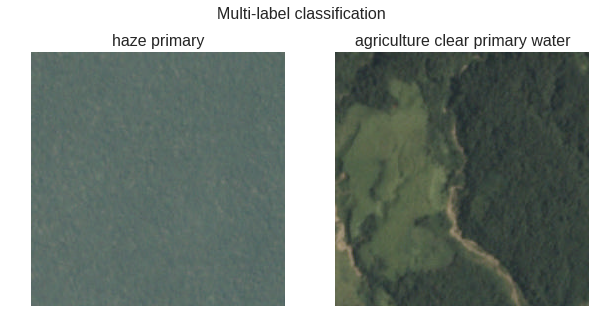

In [168]:
list_paths = [f'{PATH}train-jpg/train_0.jpg', f'{PATH}train-jpg/train_1.jpg']
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification",)
print("In multi-label classification each sample can belong to one or more clases. \n\
The first images belongs to two clases: haze and primary. \n\
The second image belongs to four clases: agriculture, clear, primary and water.")

In [203]:
# Импортируем и определяем метрику
!wget https://raw.githubusercontent.com/fastai/fastai/master/courses/dl1/planet.py
from planet import f2

metrics=[f2]
metrics

[<function planets.f2>]

In [0]:
# Модель нейросети
f_model = resnet34

In [206]:
# Файл меток
label_csv = f'{PATH}train_v2.csv'

!head -n 10  {label_csv} # показать 10 первых строк файла

image_name,tags
train_0,haze primary
train_1,agriculture clear primary water
train_2,clear primary
train_3,clear primary
train_4,agriculture clear habitation primary road
train_5,haze primary water
train_6,agriculture clear cultivation primary water
train_7,haze primary
train_8,agriculture clear cultivation primary


In [207]:
n = len(list(open(label_csv)))-1
n

40479

In [210]:
val_idxs = get_cv_idxs(n)
val_idxs

array([34602, 11243, 14499, ..., 13041, 22865, 25088])

In [213]:
# Функция подготовки картинок необходимого размера (размер минибатча по умолчанию 64)
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')
get_data

<function __main__.get_data>

In [216]:
# Подготовим для просмотра картинки размером 256
data = get_data(256)
data

In [0]:
# Объекты, создаваемые функцией get_data:

# data.train_ds # train data set
# data.train_dl # train data loader
# data.val_ds # validation data set
# data.val_dl # validation data loader
# data.test_ds # test data set
# data.test_dl # test data loader

# data set - возвращает одну картинку
# data loader - возвращает минибатч

In [221]:
# Посмотрим на минибатч валидационной выборки
x,y = next(iter(data.val_dl))
print('x -', x.shape) # массив данных картинок
print('y -', y.shape) # масссив меток
y

x - torch.Size([64, 3, 256, 256])
y - torch.Size([64, 17])



    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.FloatTensor of size 64x17]

In [222]:
# Классы картинки с индексом 0
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

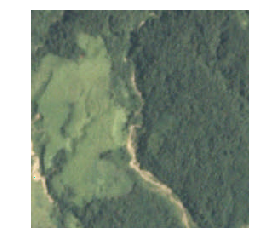

In [239]:
# Сама картинка с индексом 0 (увеличили яркость в 1.5 раз)
plt.axis('off')
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.5)

In [0]:
# Размер картинок для первоначального обучения
sz=64

In [0]:
data = get_data(sz)

In [242]:
# Уменьшим картиноки, размером больше sz*1.3 по наименьшей из сторон
# этот процесс длятся дольше, чем обучение
data = data.resize(int(sz*1.3), 'tmp')

In [243]:
# Сформируем нейросеть с метрикой f2 (beta=2)
# Метрика - оценка качества модели нейросети (точность клсассификатора)
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:31<00:00, 2814957.59it/s]


epoch      trn_loss   val_loss   f2         
    0      0.212364   0.263592   0.823546  



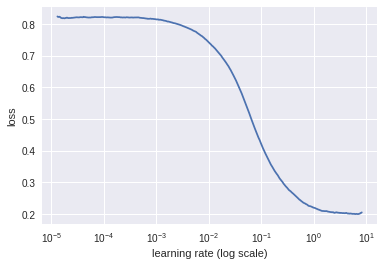

In [244]:
# Определим скорость обучения
lrf=learn.lr_find()
learn.sched.plot()

**Обучаем модель**

In [246]:
lr = 0.3
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
#learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   f2         
    0      0.144949   0.133409   0.883943  


[array([0.13341]), 0.8839433182674807]

In [0]:
lr = 0.2
learn.unfreeze()
lrs = np.array([lr/9,lr/3,lr])
#learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.fit(lrs, 1, cycle_len=1)

 39%|███▊      | 196/506 [18:11<28:45,  5.57s/it, loss=0.139]

In [0]:
# сохраняем
learn.save(f'{sz}')

In [0]:
learn.sched.plot_loss()

In [0]:
sz=128
learn.freeze()
learn.set_data(get_data(sz))
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
#learn.fit(lr, 1, cycle_len=1)

In [0]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
#learn.fit(lrs, 1, cycle_len=1)

In [0]:
learn.save(f'{sz}')
learn.sched.plot_loss()

In [0]:
sz=256
learn.freeze()
learn.set_data(get_data(sz))
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
#learn.fit(lr, 1, cycle_len=1)

In [0]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
#learn.fit(lrs, 1, cycle_len=1)

In [0]:
learn.save(f'{sz}')
learn.sched.plot_loss()

In [0]:
# Поучаем результат обучения
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [0]:
f2(preds,y)